In [1]:
# Подключение библиотек и загрузка данных
!pip install -q kaggle polars
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from google.colab import files


In [2]:
# Настройка kaggle API
!mkdir -p ~/.kaggle
uploaded = files.upload()  # Загрузите сюда свой kaggle.json вручную
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Скачивание и распаковка данных
!kaggle competitions download -c clustering-physical-activity-data
!unzip -q clustering-physical-activity-data.zip

clustering-physical-activity-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Physical_Activity_Monitoring_unlabeled.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [4]:
# Чтение данных
raw_data = pl.read_csv("Physical_Activity_Monitoring_unlabeled.csv")

In [5]:
# Количество уникальных субъектов
n_subjects = raw_data.select(pl.col("subject_id").n_unique()).to_series()[0]
print("Всего уникальных субъектов:", n_subjects)

Всего уникальных субъектов: 8


In [6]:
# Заполнение пропусков средним значением по каждому субъекту
data_cleaned = raw_data.with_columns([
    pl.when(pl.col(col).is_null())
      .then(pl.col(col).mean().over("subject_id"))
      .otherwise(pl.col(col)).alias(col)
    for col in raw_data.columns if col != "subject_id"
])

In [7]:
# Функция для добавления векторной нормы
def vector_norm(df, prefix):
    cols = [f"{prefix}{i}" for i in ["_1", "_2", "_3"]]
    return (pl.col(cols[0])**2 + pl.col(cols[1])**2 + pl.col(cols[2])**2).sqrt().alias(prefix)

In [8]:
# Добавляем все доступные нормы
norm_features = []
prefixes_done = set()

for col in raw_data.columns:
    if col.endswith("_1"):
        prefix = col[:-2]
        if prefix not in prefixes_done:
            norm_features.append(vector_norm(raw_data, prefix))
            prefixes_done.add(prefix)

# Добавим новые фичи к датафрейму
data_prepared = raw_data.with_columns(norm_features)

In [9]:
# Удаление лишних колонок (оставляем только новые признаки и метки)
to_remove = [col for col in data_cleaned.columns if any(s in col for s in ["_1", "_2", "_3"])]
to_remove += ["handTemperature", "handOrientation4", "chestTemperature", "chestOrientation4", "ankleTemperature", "ankleOrientation4"]
data_final = data_prepared.drop(to_remove)

In [10]:
# Группировка и уменьшение объема данных
subset = data_final.to_pandas().groupby("subject_id").sample(frac=0.1, random_state=42)

In [11]:
# Корреляционный анализ
features = subset.drop(columns=["subject_id"])
features = features.dropna()  # удаляем строки с NaN, если остались
corr_matrix = features.corr()
strong_corr = set()

for i in range(len(features.columns)):
    for j in range(i + 1, len(features.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            print(f"Сильная корреляция: {features.columns[i]} и {features.columns[j]}")
            strong_corr.add(features.columns[j])

features = features.drop(columns=strong_corr)


Сильная корреляция: handAcc16 и handAcc6
Сильная корреляция: chestAcc16 и chestAcc6


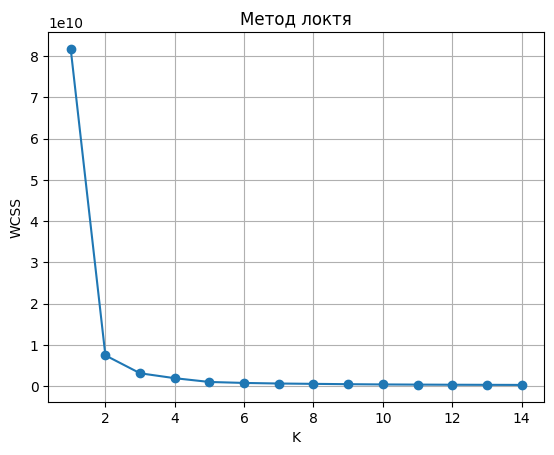

In [12]:
# Поиск оптимального количества кластеров через локоть
wcss = []
for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(features)
    wcss.append(model.inertia_)

plt.plot(range(1, 15), wcss, marker='o')
plt.title("Метод локтя")
plt.xlabel("K")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

Оптимальное число кластеров,

K=3 — после этого добавление новых кластеров почти не снижает ошибку, и модель начинает переобучаться или теряет интерпретируемость.

In [13]:
# Проверка нескольких кластеризаций ~ 3minutes
for k in [3, 4, 5]:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = model.fit_predict(features)
    score = silhouette_score(features, clusters)
    print(f"KMeans (k={k}): Silhouette Score = {score:.4f}")

KMeans (k=3): Silhouette Score = 0.7661
KMeans (k=4): Silhouette Score = 0.6264
KMeans (k=5): Silhouette Score = 0.6235


In [14]:
# Масштабирование признаков для DBSCAN и агломеративного анализа
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

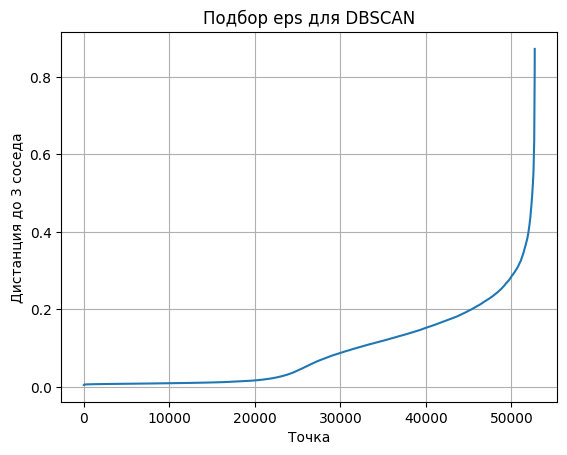

In [15]:
# DBSCAN: подбор eps
neighbors = NearestNeighbors(n_neighbors=3, n_jobs=-1).fit(features_scaled)
distances, _ = neighbors.kneighbors(features_scaled)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.title("Подбор eps для DBSCAN")
plt.xlabel("Точка")
plt.ylabel("Дистанция до 3 соседа")
plt.grid(True)
plt.show()

Можно выбрать eps ≈ 0.15–0.2 — это порог, который отделяет плотные области от разреженных (выбросов).

In [16]:
# DBSCAN кластеризация
db_model = DBSCAN(eps=0.15, min_samples=3, n_jobs=-1)
db_clusters = db_model.fit_predict(features_scaled)
print("Silhouette DBSCAN:", silhouette_score(features_scaled, db_clusters))

Silhouette DBSCAN: 0.1289932847499822


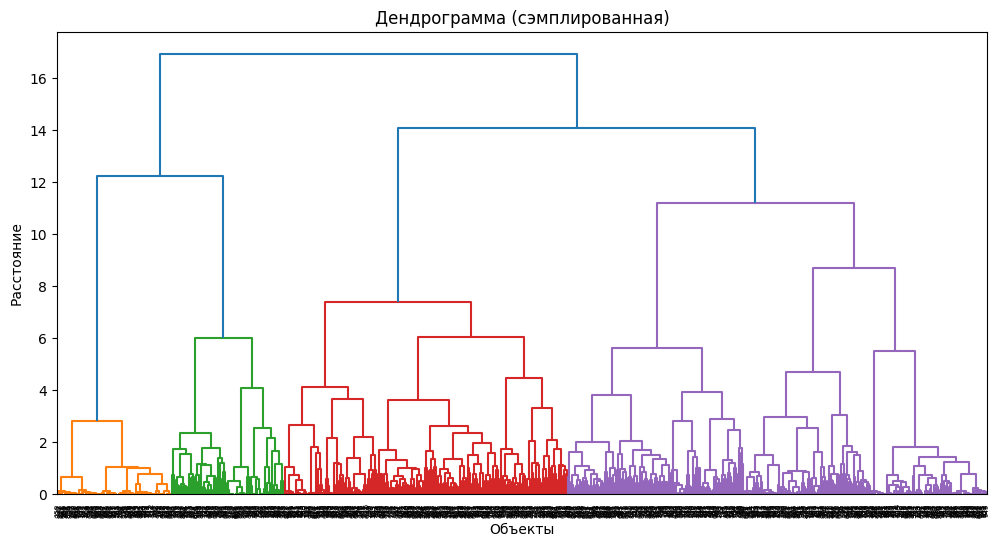

In [17]:
# Иерархическая кластеризация (без полной дендрограммы — экономим RAM - слабый ПК)
sample_size = 1000
if len(features_scaled) > sample_size:
    sample_idx = np.random.choice(len(features_scaled), sample_size, replace=False)
    sampled_features = features_scaled[sample_idx]
else:
    sampled_features = features_scaled

linkage_matrix = linkage(sampled_features, method="ward")
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title("Дендрограмма (сэмплированная)")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.show()

Чем выше точка слияния на дендрограмме, тем менее похожи были сливающиеся кластеры.

На графике видно, что высоко сливаются 3 крупных ветви — это говорит о наличии примерно 3 логичных кластеров.

In [18]:
# Сравнение кластеризации агломеративной (сэмплированной — экономим RAM)
sample_size = 2000
agg_sample = features.sample(n=sample_size, random_state=42) if len(features) > sample_size else features

for k in [3, 4, 5]:
    agg_model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    agg_labels = agg_model.fit_predict(agg_sample)
    score = silhouette_score(agg_sample, agg_labels)
    print(f"Agglomerative (k={k}): Silhouette Score = {score:.4f}")

Agglomerative (k=3): Silhouette Score = 0.7701
Agglomerative (k=4): Silhouette Score = 0.6129
Agglomerative (k=5): Silhouette Score = 0.6064


In [20]:
# Финальное обучение и подготовка submission
full_data = data_final.to_pandas()

# Заполняем пропуски средними значениями по колонкам
full_data = full_data.fillna(full_data.mean(numeric_only=True))

# Обучение модели
x_full = full_data.drop(columns=["subject_id"])
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
full_clusters = kmeans_final.fit_predict(x_full)

# Присваиваем activityID
full_data["cluster"] = full_clusters
full_data["activityID"] = -1
for idx, val in enumerate(sorted(full_data["cluster"].unique()), start=1):
    full_data.loc[full_data["cluster"] == val, "activityID"] = idx

# Формируем submission файл
submission = full_data[["activityID"]].reset_index()
submission.columns = ["Index", "activityID"]
submission.to_csv("submission_final.csv", index=False)

submission.head()

,Index,activityID
0,0,1
1,1,2
2,2,1
3,3,2
4,4,1


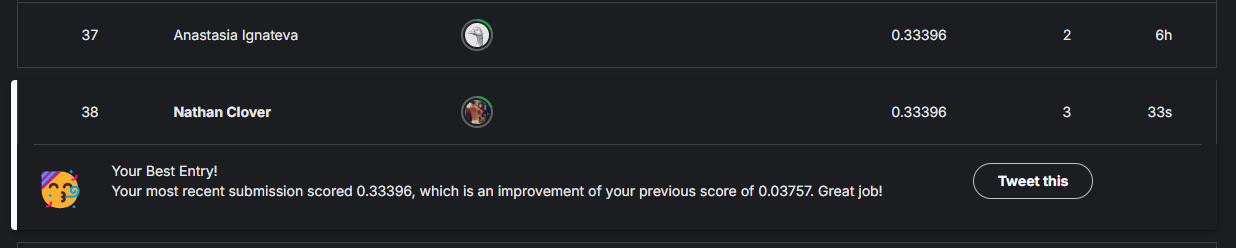